# Binarization and different approches for background subtraction

**Created on:** 01/11/2024  
**Author:** Dmitry Chezganov  

# Binarization Approaches

This notebook explores various binarization techniques to process images/data for defect or particle analysis. The binarization process converts grayscale images to binary, which is essential for tasks like segmentation, object recognition, and feature extraction. This analysis includes:

1. **Data Preparation and Preprocessing:** Loading and normalizing data to optimize binarization results.
2. **Binarization Methods:** Comparing multiple approaches (e.g., Otsu’s thresholding, adaptive thresholding, and custom thresholding techniques).
3. **Evaluation Metrics:** Analyzing each approach based on accuracy, contrast preservation, and computational efficiency.
4. **Visualization and Comparison:** Visualizing the results to assess differences across methods and identify the most effective technique for the dataset.

This notebook provides insights into the strengths and limitations of each binarization method, aiding in selecting the best approach for specific applications.

1. Import necessary libraries.
2. Load and preprocess the image.
3. Interactive selection of the region of interest (ROI) in the image.
4. Background subtraction using various methods.
5. Binarization of the image using threshold values.
6. Morphological processing to clean the image.
7. Calculation of the white/black ratio.
8. Visualization of the results.


In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from skimage import exposure
from ipywidgets import interact, IntSlider
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import cv2

### Indicate the path to the image, and load it, and convert it to grayscale, check the image

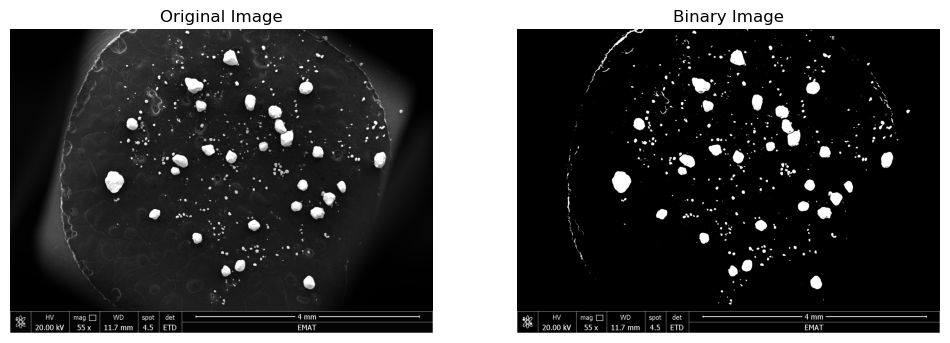

In [29]:
# Load image
path = './image_example/11_437_001.tif'

# Tk().withdraw()
# path = askopenfilename()

# Load image
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# Ensure the image is loaded correctly
if image is None:
	raise FileNotFoundError(f"Image not found at the path: {path}")

# make binary
_, image_b = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(image_b, cmap='gray')
ax[1].set_title('Binary Image')
for a in ax:
	a.axis('off')
plt.show()

### Cut the image interactively to the region of interest

In [30]:
# global variables
global image_cut

# Function for interactive ROI selection
def interactive_image_cut(x1, y1, x2, y2):
    global image_cut
    image_cut = image[y1:y2, x1:x2]
    plt.imshow(image_cut, cmap='gray')
    plt.axis('off')
    plt.show()

# Display sliders for interactive ROI selection
interact(interactive_image_cut,
            x1=IntSlider(min=0, max=image.shape[1], step=1, value=0, description='X1'),
            y1=IntSlider(min=0, max=image.shape[0], step=1, value=0, description='Y1'),
            x2=IntSlider(min=0, max=image.shape[1], step=1, value=image.shape[1], description='X2'),
            y2=IntSlider(min=0, max=image.shape[0], step=1, value=image.shape[0], description='Y2'))

interactive(children=(IntSlider(value=0, description='X1', max=1536), IntSlider(value=0, description='Y1', max…

<function __main__.interactive_image_cut(x1, y1, x2, y2)>

### Background subtraction v1

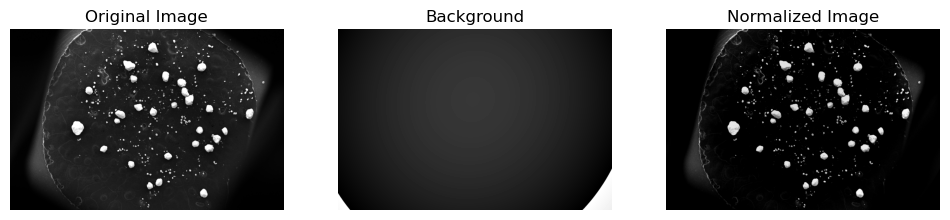

In [31]:
image = image_cut

rows, cols = image.shape
X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
Z = image

# Prepare data for polynomial regression
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()

# Polynomial regression
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(np.column_stack((X_flat, Y_flat)))
model = LinearRegression().fit(X_poly, Z_flat)

# Background prediction
Z_pred = model.predict(X_poly).reshape(rows, cols)

background = Z_pred.astype(np.uint8)

# Background subtraction
normalized = cv2.subtract(image, background)

# plot
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(background, cmap='gray')
ax[1].set_title('Background')
ax[2].imshow(normalized, cmap='gray')
ax[2].set_title('Normalized Image')
for a in ax:
    a.axis('off')
plt.show()

### Background subtraction v2

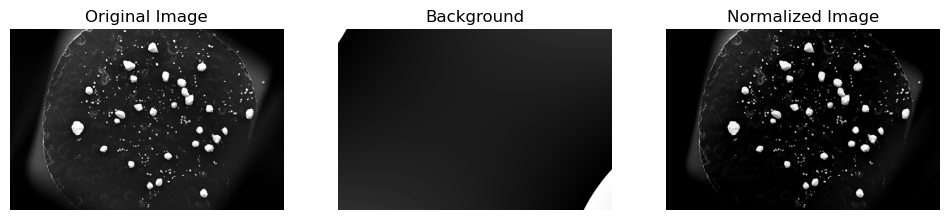

In [32]:
image = image_cut
rows, cols = image.shape
X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
Z = image

# Prepare data for polynomial regression
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()

# Polynomial regression with RANSAC
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(np.column_stack((X_flat, Y_flat)))
ransac = RANSACRegressor().fit(X_poly, Z_flat)

# Background prediction
Z_pred = ransac.predict(X_poly).reshape(rows, cols)

background = Z_pred.astype(np.uint8)

# Background subtraction
normalized = cv2.subtract(image, background)

# plot
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(background, cmap='gray')
ax[1].set_title('Background')
ax[2].imshow(normalized, cmap='gray')
ax[2].set_title('Normalized Image')
for a in ax:
    a.axis('off')
plt.show()

### Background subtraction v3

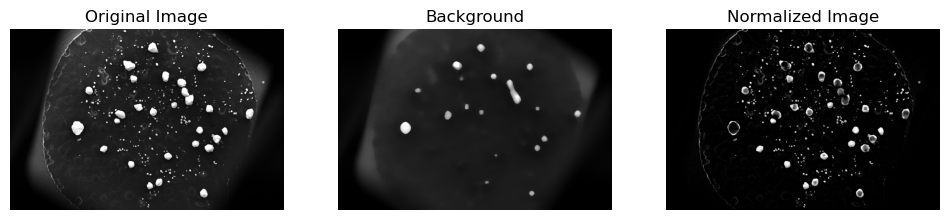

In [33]:
image = image_cut
# Median filtering
background = cv2.medianBlur(image, 51)

# Background subtraction
normalized = cv2.subtract(image, background)

# plot
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(background, cmap='gray')
ax[1].set_title('Background')
ax[2].imshow(normalized, cmap='gray')
ax[2].set_title('Normalized Image')
for a in ax:
    a.axis('off')
plt.show()

### Background subtraction v4

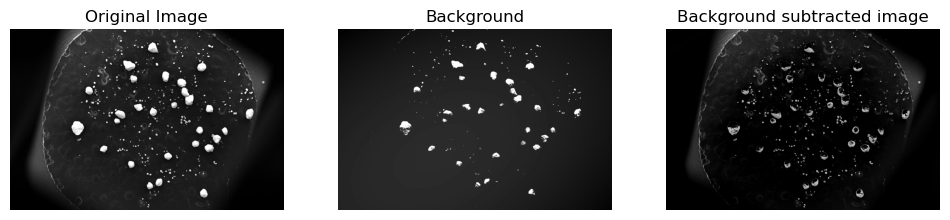

In [34]:
# Create mask to exclude white areas (edges)
image = image_cut
mask = np.where(image < 255, 1, 0).astype(np.uint8)
# mask = np.where(image > 0, 1, 0).astype(np.uint8)

# Determine significant pixels
X, Y = np.nonzero(mask)
Z = image[X, Y]

# Prepare data for polynomial regression
data = np.column_stack((X, Y))
poly = PolynomialFeatures(degree=2)
data_poly = poly.fit_transform(data)

# RANSAC model for background approximation
ransac = RANSACRegressor()
ransac.fit(data_poly, Z)
Z_pred = ransac.predict(data_poly)

# Restore background
background = np.full_like(image, 255, dtype=np.float64)
background[X, Y] = Z_pred

# Background subtraction
normalized = cv2.subtract(image, background.astype(np.uint8))

# plot
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(background, cmap='gray')
ax[1].set_title('Background')
ax[2].imshow(normalized, cmap='gray')
ax[2].set_title('Background subtracted image')
for a in ax:
    a.axis('off')
plt.show()

### Filtering

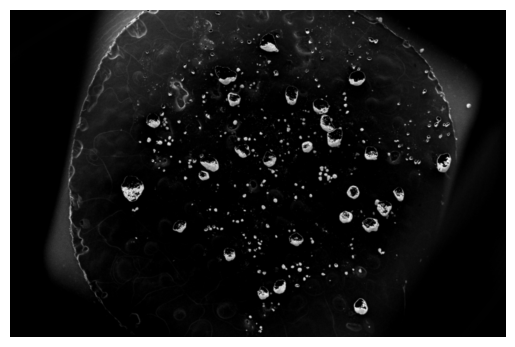

In [35]:
# normalized = image

# Filtering to reduce noise
filtered = cv2.GaussianBlur(normalized, (5, 5), 0)
#plot
plt.imshow(filtered, cmap='gray')
plt.axis('off')
plt.show()

 ### Binarization with 2 sliders

In [36]:

#! change the variable naming here
filtered = image_cut

# %matplotlib qt5
%matplotlib inline

# Auto binarization
_, binary_auto = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# global variables
global_binary = None

# Function for interactive binarization with two thresholds
def interactive_binarization(lower_threshold, upper_threshold):
    global global_binary
    _, binary_lower = cv2.threshold(filtered, lower_threshold, 255, cv2.THRESH_BINARY)
    _, binary_upper = cv2.threshold(filtered, upper_threshold, 255, cv2.THRESH_BINARY_INV)
    global_binary = cv2.bitwise_and(binary_lower, binary_upper)
    
    fig, ax = plt.subplots(2, 2, 
                            # figsize=(12, 12), 
                            dpi=300)
    ax[0, 0].imshow(image, cmap='gray')
    ax[0, 0].set_title('Original Image')
    ax[0, 1].imshow(filtered, cmap='gray')
    ax[0, 1].set_title('Background Subtracted Image')
    ax[1, 0].imshow(binary_auto, cmap='gray')
    ax[1, 0].set_title('Binary Image (auto threshold)')
    ax[1, 1].imshow(global_binary, cmap='gray')
    ax[1, 1].set_title('Binary Image (manual threshold)')
    plt.tight_layout()
    for axx in ax.flat:
        axx.axis('off')
    plt.show()


# Display sliders for interactive threshold selection
interact(interactive_binarization,
        lower_threshold=IntSlider(min=0, max=255, step=1, value=50, description='Lower Threshold'),
        upper_threshold=IntSlider(min=0, max=255, step=1, value=150, description='Upper Threshold'))

interactive(children=(IntSlider(value=50, description='Lower Threshold', max=255), IntSlider(value=150, descri…

<function __main__.interactive_binarization(lower_threshold, upper_threshold)>

### Morphological processing

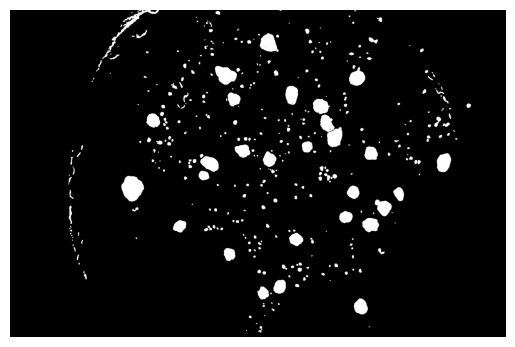

In [37]:
# cleaned
# Morphological processing
kernel = np.ones((3, 3), np.uint8)
cleaned = cv2.morphologyEx(global_binary, cv2.MORPH_OPEN, kernel)

# plot
plt.imshow(cleaned, cmap='gray')
plt.axis('off')
plt.show()

### White/black ratio calculation

In [ ]:
# Calculate the ratio of defect area to total area
total_area = np.count_nonzero(mask)
defect_area = np.sum(cleaned == 255)
ratio = defect_area / total_area

print(f'White/black ratio: {ratio:.4f}')

White/black ratio: 0.0433


### Visualization

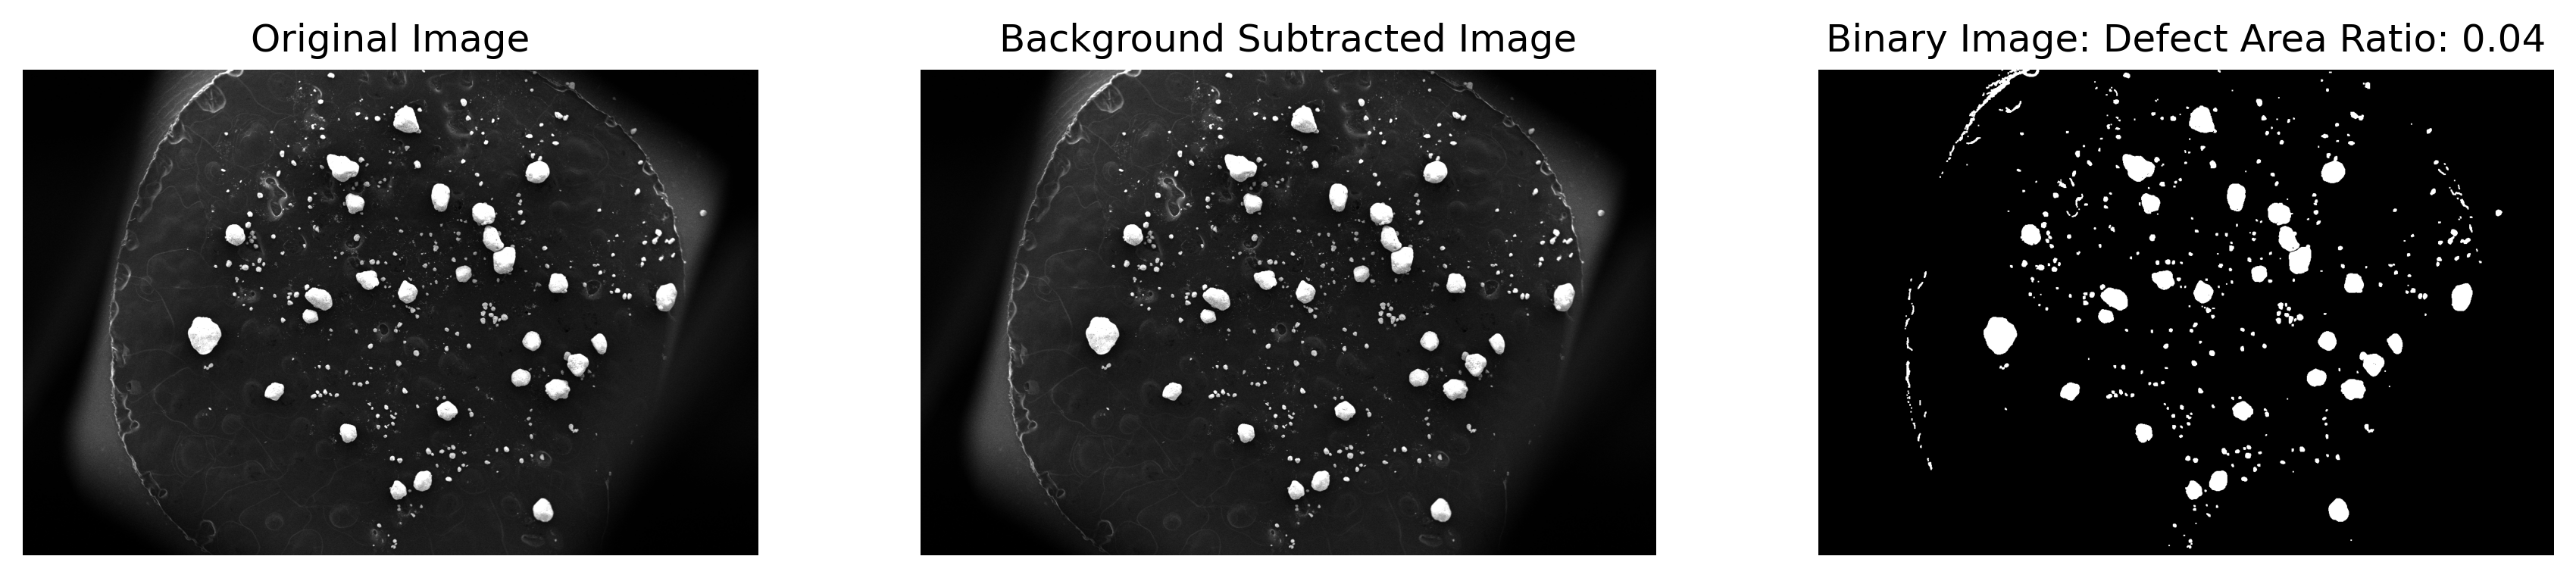

In [39]:
fig, ax = plt.subplots(1, 3, 
                        figsize=(12, 6),
                        dpi=300)
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(filtered, cmap='gray')
ax[1].set_title('Background Subtracted Image')
ax[2].imshow(cleaned, cmap='gray')
# ax[2].text(10, 70, f'Defect Area Ratio: {ratio:.2f}', color='white')
ax[2].set_title(f'Binary Image: Defect Area Ratio: {ratio:.2f}')
plt.tight_layout()
for axx in ax.flat:
    axx.axis('off')
plt.show()